In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import math
import itertools
import matplotlib.pyplot as plt
import tensorflow_probability.python.experimental.substrates.jax as tfp
from IMNN.experimental.jax.imnn import SimulatorIMNN
from IMNN.experimental.jax.lfi import GaussianApproximation
rng = jax.random.PRNGKey(0)

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Simulator in JAX

In [3]:
θ_fid = np.array([0., 1.])
n_params = 2
input_shape = (10,)
simulator_args = {"input shape": input_shape}

In [4]:
def simulator(rng, θ, simulator_args=simulator_args):
    μ, Σ = θ
    def fn(key, μ, Σ):
        return μ + np.sqrt(Σ) * jax.random.normal(key, shape=simulator_args["input shape"])
    if μ.shape == Σ.shape:
        if len(μ.shape) == 0:
            return fn(rng, μ, Σ)
        else:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ, Σ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, μ, Σ)
    else:
        if len(μ.shape) > 0:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, μ)
        elif len(Σ.shape) > 0:
            keys = jax.random.split(rng, num=Σ.shape[0])
            return jax.vmap(lambda key, Σ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, Σ)

In [5]:
μs = [np.zeros(()), np.zeros((1,)), np.zeros((2,)), np.zeros((1, 1)), np.zeros((1, 2)), np.zeros((2, 1)), np.zeros((2, 2)), np.zeros((1, 2, 3)), np.zeros((2, 1, 3)), np.zeros((3, 2, 1))] 
Σs = [np.ones(()), np.ones((1,)), np.ones((2,)), np.ones((1, 1)), np.ones((1, 2)), np.ones((2, 1)), np.ones((2, 2)), np.ones((1, 2, 3)), np.ones((2, 1, 3)), np.ones((3, 2, 1))]
for θ in itertools.product(μs[:2], Σs[:2]):
    simulation = simulator(rng, θ, simulator_args=simulator_args)
    print(θ[0].shape, θ[1].shape, simulation.shape)

() () (10,)
() (1,) (1, 10)
(1,) () (1, 10)
(1,) (1,) (1, 10)


# Data for ABC example

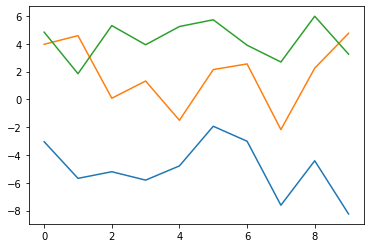

In [6]:
rng, key = jax.random.split(rng)
target_data = simulator(key, (np.array([-5., 2., 4.]), np.array([2., 5., 1.])), simulator_args=simulator_args)
plt.plot(target_data.T);

In [7]:
prior = tfp.distributions.JointDistributionSequential([
    tfp.distributions.Uniform(-10., 10.),
    tfp.distributions.Uniform(0., 10.)])
prior.low = [-10., 0.]
prior.high = [10., 10.]

In [8]:
abc_samples = int(1e7)
rng, key = jax.random.split(rng)
θ_abc = prior.sample(abc_samples, seed=rng)
abc_simulations = simulator(key, θ_abc, simulator_args=simulator_args)

# Model in STAX

In [9]:
n_summaries = 5
n_s = 1000
n_d = 1000
λ = 10.
ϵ = 0.01
α = - math.log(ϵ * (λ - 1.) + ϵ**2. / (1 + ϵ)) / ϵ

In [10]:
model = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries))

In [11]:
optimiser = optimizers.adam(step_size=1e-3)

# Random seeds for IMNN

In [12]:
rng, initial_model_seed = jax.random.split(rng)
rng, fitting_seed = jax.random.split(rng)

# Simulations on the fly

### Initialise IMNN

In [13]:
imnn = SimulatorIMNN(n_s=n_s, n_d=n_d, n_summaries=n_summaries, input_shape=input_shape, 
                     θ_fid=θ_fid, key=initial_model_seed, model=model, optimiser=optimiser, 
                     simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args))

#### Fit

In [14]:
imnn.fit(λ=λ, α=α, rng=fitting_seed)

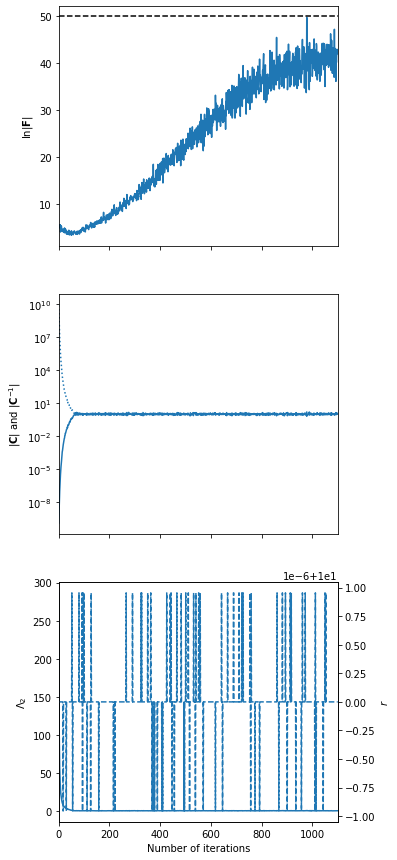

In [15]:
imnn.training_plot(expected_detF=50);

In [16]:
target_summaries = imnn.get_estimate(target_data)

In [17]:
GA = GaussianApproximation(target_summaries, imnn.invC, prior)

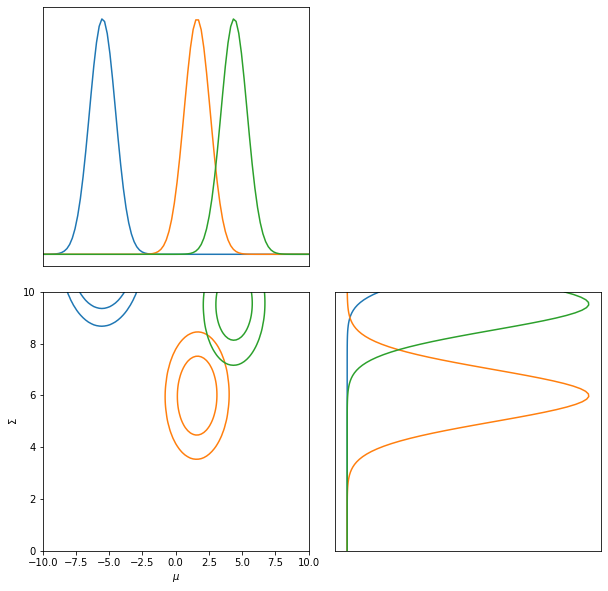

In [20]:
GA.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"]);